In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
import pymc3 as pm
from theano import tensor as tt
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import string
from itertools import product
from numpy.random import normal, exponential, seed
import warnings

# Remove annoying filters from some dated ArViz functions.
warnings.simplefilter(action="ignore", category=UserWarning)

# Default theme for Plotnine.
gg.theme_set(gg.theme_minimal())

# A value to use in all random seed setting instances.
RANDOM_SEED = 103

---

## Model 7. Generation using varying sgRNA|gene and cell line effects

Model the effects of knocking out gene $g$ with sgRNA $s$ in cell line $c$.
The data will be generated with the following model, but then different models structures will be tested.

$
logFC_{s,c} \sim \mathcal{N}(\mu_{s,c}, \sigma) \\
\mu_{s,c} = \alpha_s + \beta_c \\
\quad \alpha_s \sim \mathcal{N}(\mu_{\alpha_s}, \sigma_\alpha) \\
\qquad \mu_{\alpha_s} = \gamma_g \\
\qquad\quad \gamma_g \sim \mathcal{N}(\mu_\gamma, \sigma_\gamma) \\
\qquad\qquad \mu_\gamma \sim \mathcal{N}(0, 5) \quad \sigma_\gamma \sim \text{Exp}(1) \\
\qquad \sigma_\alpha \sim \text{Exp}(1) \\
\quad \beta_c \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\qquad \mu_\beta \sim \mathcal{N}(0, 5) \quad \sigma_\beta \sim \text{Exp}(1) \\
\sigma \sim \text{Exp}(1)
$

Simulated values:

- number of cell lines: 20
- number of genes: 10
- number of repeated measures: $[1 , 2 , \dots , 10]$
- $\mu_\gamma = -1.0$, $\sigma_\gamma = 0.5$
- $\sigma_\alpha = 0.2$
- $\mu_\beta = 0$, $\sigma_\beta = 1$
- $\sigma = 0.3$

In [2]:
def prefixed_count(prefix, n, plus=0):
    """Make an array of 1-n with the number and some prefix."""
    return [prefix + str(i + plus) for i in range(n)]

In [3]:
def make_cat(df, col, ordered=True):
    """Make a column of a data frame into a categorical data type."""
    vals = df[col].drop_duplicates().to_list()
    df[col] = pd.Categorical(df[col], categories=vals, ordered=ordered)
    return df

In [4]:
seed(RANDOM_SEED)

num_cell_lines = 20
num_genes = 10
num_sgrna_per_gene = list(range(1, num_genes + 1))
num_sgrnas = sum(num_sgrna_per_gene)

cell_lines = prefixed_count("cell_", num_cell_lines)
genes = prefixed_count("gene_", num_genes)
sgrnas = prefixed_count("sgRNA_", num_sgrnas)

# RP ("real parameters")
RP = {
    "mu_gamma": -1.0,
    "sigma_gamma": 0.5,
    "sigma_alpha": 0.2,
    "mu_beta": 0.0,
    "sigma_beta": 1.0,
    "sigma": 0.3,
}

RP["gamma_g"] = normal(loc=RP["mu_gamma"], scale=RP["sigma_gamma"], size=num_genes)
RP["beta_c"] = normal(loc=RP["mu_beta"], scale=RP["sigma_beta"], size=num_cell_lines)

sgrna_df = pd.DataFrame({"gene": np.repeat(genes, num_sgrna_per_gene), "sgRNA": sgrnas})
for col in sgrna_df.columns:
    sgrna_df = make_cat(sgrna_df, col)

alpha_s = []
for gene_i in sgrna_df["gene"].cat.codes:
    alpha_s.append(normal(loc=RP["gamma_g"][gene_i], scale=RP["sigma_alpha"]))


RP["alpha_s"] = alpha_s

data = pd.DataFrame(product(cell_lines, sgrnas), columns=["cell_line", "sgRNA"])
data = data.merge(sgrna_df, on="sgRNA")


for col in data.columns:
    data = make_cat(data, col)


for i in range(len(data)):
    cell_i = data["cell_line"].cat.codes[i]
    sgrna_i = data["sgRNA"].cat.codes[i]
    mu_sc = RP["alpha_s"][sgrna_i] + RP["beta_c"][cell_i]
    data.loc[i, "mu_sc"] = mu_sc
    data.loc[i, "log_fc"] = normal(loc=mu_sc, scale=RP["sigma"])

data

,cell_line,sgRNA,gene,mu_sc,log_fc
0,cell_0,sgRNA_0,gene_0,-1.284686,-0.974021
1,cell_1,sgRNA_0,gene_0,-1.986886,-2.358464
2,cell_2,sgRNA_0,gene_0,-0.883180,-0.911884
3,cell_3,sgRNA_0,gene_0,-0.267206,-0.774813
4,cell_4,sgRNA_0,gene_0,-3.064072,-2.866197
...,...,...,...,...,...
1095,cell_15,sgRNA_54,gene_9,-2.116856,-2.188318
1096,cell_16,sgRNA_54,gene_9,-2.245777,-1.630069
1097,cell_17,sgRNA_54,gene_9,-1.079010,-0.752161
1098,cell_18,sgRNA_54,gene_9,-1.900383,-1.697479


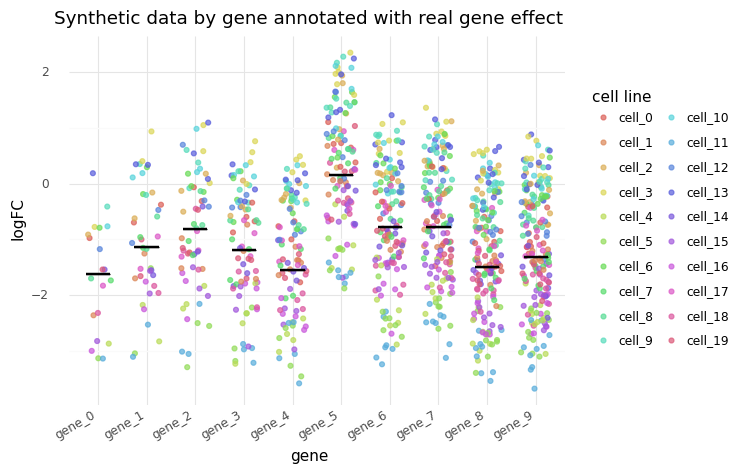

<ggplot: (8759225604054)>

In [5]:
real_gene_vals = pd.DataFrame({"gene": genes, "log_fc": RP["gamma_g"]})

(
    gg.ggplot(data, gg.aes(x="gene", y="log_fc"))
    + gg.geom_jitter(gg.aes(color="cell_line"), height=0, width=0.3, alpha=0.7)
    + gg.geom_crossbar(gg.aes(ymin="log_fc", ymax="log_fc"), data=real_gene_vals)
    + gg.scale_color_discrete(guide=gg.guide_legend(title="cell line", ncol=2))
    + gg.theme(axis_text_x=gg.element_text(angle=30, hjust=1, vjust=0.2))
    + gg.labs(
        x="gene",
        y="logFC",
        title="Synthetic data by gene annotated with real gene effect",
    )
)

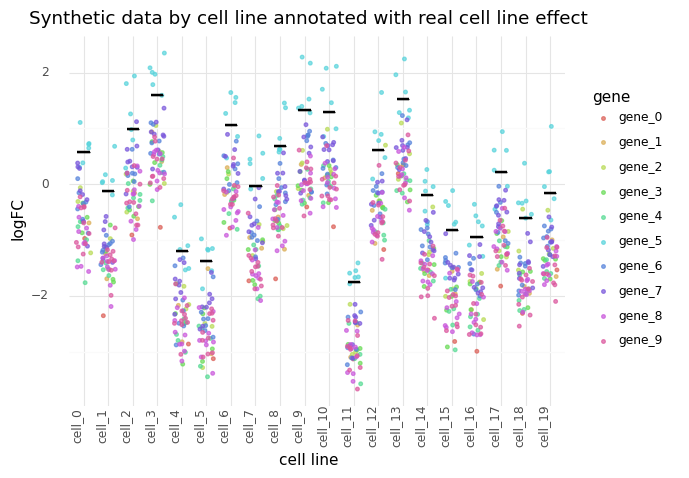

<ggplot: (8759224964331)>

In [6]:
real_cellline_vals = pd.DataFrame({"cell_line": cell_lines, "log_fc": RP["beta_c"]})

(
    gg.ggplot(data, gg.aes(x="cell_line", y="log_fc"))
    + gg.geom_jitter(gg.aes(color="gene"), height=0, width=0.3, alpha=0.7, size=1)
    + gg.geom_crossbar(gg.aes(ymin="log_fc", ymax="log_fc"), data=real_cellline_vals)
    + gg.scale_color_discrete(guide=gg.guide_legend(title="gene", ncol=1))
    + gg.theme(axis_text_x=gg.element_text(angle=90, hjust=1, vjust=0.5))
    + gg.labs(
        x="cell line",
        y="logFC",
        title="Synthetic data by cell line annotated with real cell line effect",
    )
)

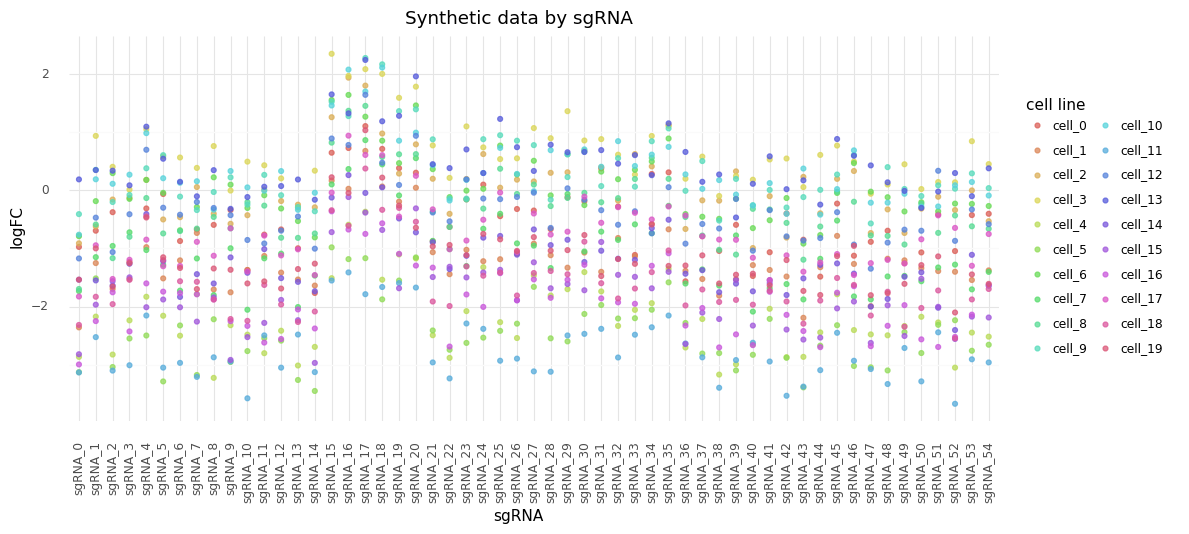

<ggplot: (8759224964151)>

In [7]:
real_cellline_vals = pd.DataFrame({"cell_line": cell_lines, "log_fc": RP["beta_c"]})

(
    gg.ggplot(data, gg.aes(x="sgRNA", y="log_fc"))
    + gg.geom_jitter(gg.aes(color="cell_line"), height=0, width=0, alpha=0.75)
    + gg.scale_color_discrete(guide=gg.guide_legend(title="cell line", ncol=2))
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1), figure_size=(12, 5)
    )
    + gg.labs(x="sgRNA", y="logFC", title="Synthetic data by sgRNA",)
)

## Model 7a. A 2-Dimensional varying intercept.

$
logFC_{i,g,c} \sim \mathcal{N}(\mu_{g,c}, \sigma) \\
\mu_{g,c} = \alpha_{g,c} \\
\quad \alpha_{g,c} \sim \mathcal{N}(\mu_{\alpha_{g,c}}, \sigma_\alpha) \\
\qquad \mu_{\alpha_{g,c}} \sim \mathcal{N}(0,5) \quad \sigma_\alpha \sim \text{Exp}(1) \\
\sigma \sim \text{Exp}(1)
$

In [8]:
gene_idx = data.gene.cat.codes.to_list()
cell_line_idx = data.cell_line.cat.codes.to_list()

with pm.Model() as m7a:
    # Hyper-priors
    mu_alpha_gc = pm.Normal("mu_alpha_gc", 0, 5)
    sigma_alpha = pm.Exponential("sigma_alpha", 1)

    # Linear model parameters
    alpha_gc = pm.Normal(
        "alpha_gc", mu_alpha_gc, sigma_alpha, shape=(num_genes, num_cell_lines)
    )

    # Linear model
    mu_gc = pm.Deterministic("mu_gc", alpha_gc[gene_idx, cell_line_idx])
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    log_fc = pm.Normal("log_fc", mu_gc, sigma, observed=data.log_fc.to_list())

    # Sampling
    m7a_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    m7a_trace = pm.sample(2000, tune=2000, random_seed=RANDOM_SEED, target_accept=0.95)
    m7a_post_check = pm.sample_posterior_predictive(m7a_trace, random_seed=RANDOM_SEED)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 25 seconds.
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


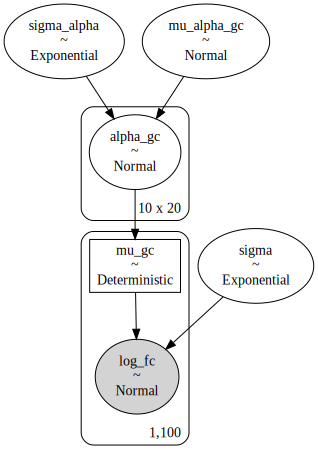

In [9]:
pm.model_to_graphviz(m7a)

In [10]:
az_m7a = az.from_pymc3(
    trace=m7a_trace,
    model=m7a,
    posterior_predictive=m7a_post_check,
    prior=m7a_prior_check,
)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [11]:
m7a_post = (
    az.summary(az_m7a, var_names=["alpha_gc"])
    .reset_index()
    .rename(columns={"index": "intercept"})
    .assign(
        gene_idx=lambda d: d["intercept"].str.extract(r"\[(\d+),"),
        cell_line_idx=lambda d: d["intercept"].str.extract(r",(\d+)\]"),
    )
    .assign(
        gene_idx=lambda d: [int(x) for x in d.gene_idx],
        gene=lambda d: [genes[i] for i in d.gene_idx],
        cell_line_idx=lambda d: [int(x) for x in d.cell_line_idx],
        cell_line=lambda d: [cell_lines[i] for i in d.cell_line_idx],
    )
)
m7a_post.head(n=10)

,intercept,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,gene_idx,cell_line_idx,gene,cell_line
0,"alpha_gc[0,0]",-0.972,0.327,-1.561,-0.362,0.003,0.002,14043.0,11904.0,14082.0,6079.0,1.0,0,0,gene_0,cell_0
1,"alpha_gc[0,1]",-2.230,0.329,-2.864,-1.631,0.003,0.002,14008.0,13747.0,14010.0,5482.0,1.0,0,1,gene_0,cell_1
2,"alpha_gc[0,2]",-0.912,0.331,-1.516,-0.274,0.003,0.002,12070.0,10600.0,12058.0,5677.0,1.0,0,2,gene_0,cell_2
3,"alpha_gc[0,3]",-0.789,0.335,-1.406,-0.152,0.003,0.002,13450.0,10194.0,13453.0,5940.0,1.0,0,3,gene_0,cell_3
4,"alpha_gc[0,4]",-2.692,0.335,-3.307,-2.054,0.003,0.002,14792.0,14280.0,14820.0,5968.0,1.0,0,4,gene_0,cell_4
5,"alpha_gc[0,5]",-2.934,0.335,-3.578,-2.310,0.003,0.002,12694.0,12551.0,12683.0,6005.0,1.0,0,5,gene_0,cell_5
6,"alpha_gc[0,6]",-0.800,0.335,-1.405,-0.148,0.003,0.002,16092.0,11237.0,16109.0,6175.0,1.0,0,6,gene_0,cell_6
7,"alpha_gc[0,7]",-1.661,0.334,-2.290,-1.041,0.003,0.002,13435.0,12682.0,13434.0,5346.0,1.0,0,7,gene_0,cell_7
8,"alpha_gc[0,8]",-1.630,0.337,-2.245,-0.978,0.003,0.002,12626.0,11765.0,12662.0,5187.0,1.0,0,8,gene_0,cell_8
9,"alpha_gc[0,9]",-0.460,0.332,-1.089,0.164,0.003,0.003,15090.0,7381.0,15109.0,5020.0,1.0,0,9,gene_0,cell_9


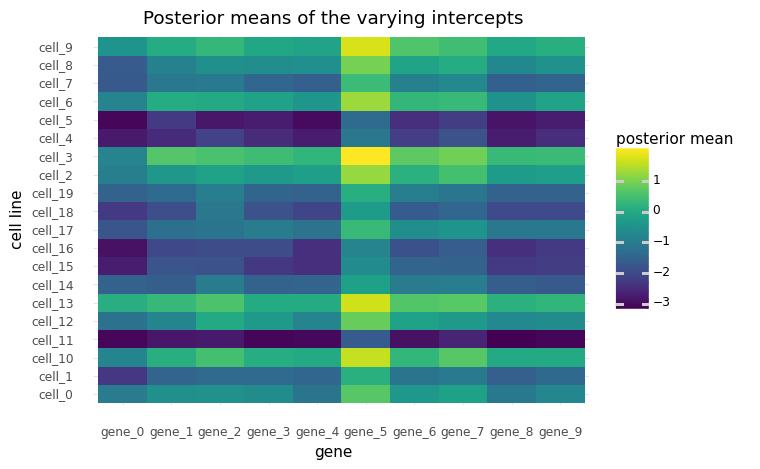

<ggplot: (8759201241432)>

In [12]:
(
    gg.ggplot(m7a_post, gg.aes(x="gene", y="cell_line"))
    + gg.geom_tile(gg.aes(fill="mean"))
    + gg.labs(
        x="gene",
        y="cell line",
        fill="posterior mean",
        title="Posterior means of the varying intercepts",
    )
)

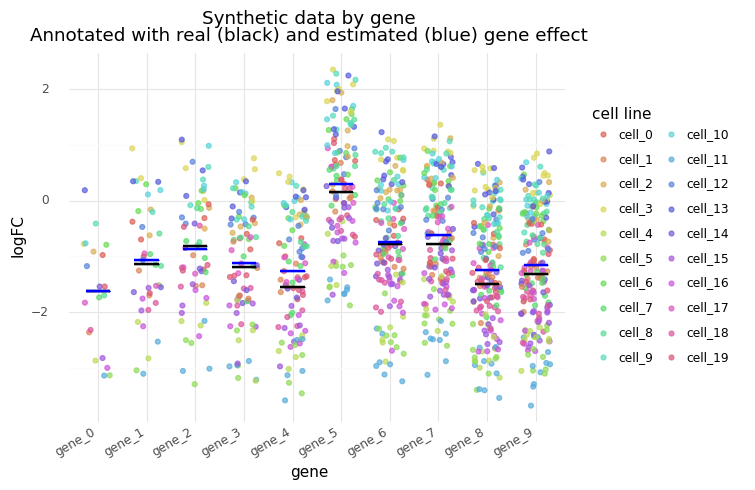

<ggplot: (8759201252729)>

In [13]:
real_gene_vals = pd.DataFrame({"gene": genes, "log_fc": RP["gamma_g"]})
gene_posteriors = m7a_post[["gene", "mean"]].groupby("gene").mean().reset_index()

(
    gg.ggplot(data, gg.aes(x="gene", y="log_fc"))
    + gg.geom_jitter(gg.aes(color="cell_line"), height=0, width=0.3, alpha=0.7)
    + gg.geom_crossbar(gg.aes(ymin="log_fc", ymax="log_fc"), data=real_gene_vals)
    + gg.geom_crossbar(
        gg.aes(ymin="mean", ymax="mean", y="mean"), data=gene_posteriors, color="blue"
    )
    + gg.scale_color_discrete(guide=gg.guide_legend(title="cell line", ncol=2))
    + gg.theme(axis_text_x=gg.element_text(angle=30, hjust=1, vjust=0.2))
    + gg.labs(
        x="gene",
        y="logFC",
        title="Synthetic data by gene\nAnnotated with real (black) and estimated (blue) gene effect",
    )
)

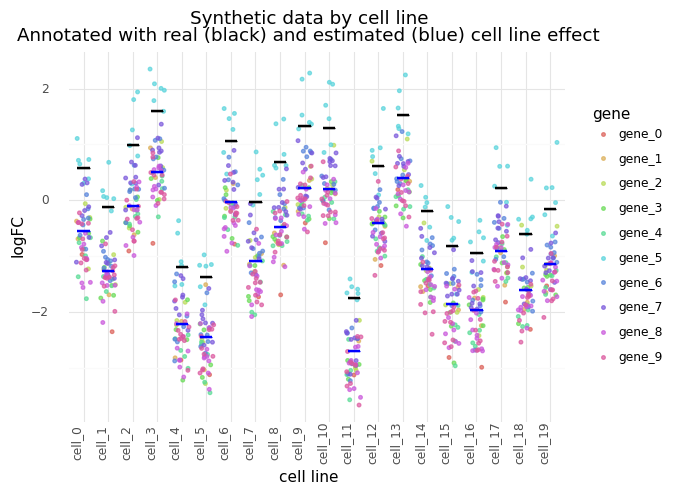

<ggplot: (8759201180823)>

In [14]:
real_cellline_vals = pd.DataFrame({"cell_line": cell_lines, "log_fc": RP["beta_c"]})
cell_line_posteriors = (
    m7a_post[["cell_line", "mean"]].groupby("cell_line").mean().reset_index()
)

(
    gg.ggplot(data, gg.aes(x="cell_line", y="log_fc"))
    + gg.geom_jitter(gg.aes(color="gene"), height=0, width=0.3, alpha=0.7, size=1)
    + gg.geom_crossbar(gg.aes(ymin="log_fc", ymax="log_fc"), data=real_cellline_vals)
    + gg.geom_crossbar(
        gg.aes(ymin="mean", ymax="mean", y="mean"),
        data=cell_line_posteriors,
        color="blue",
    )
    + gg.scale_color_discrete(guide=gg.guide_legend(title="gene", ncol=1))
    + gg.theme(axis_text_x=gg.element_text(angle=90, hjust=1, vjust=0.5))
    + gg.labs(
        x="cell line",
        y="logFC",
        title="Synthetic data by cell line\nAnnotated with real (black) and estimated (blue) cell line effect",
    )
)

In [15]:
gene_idx = data.gene.cat.codes.to_list()
cell_line_idx = data.cell_line.cat.codes.to_list()

with pm.Model() as m7a_pool:

    # Linear model parameters
    alpha_gc = pm.Normal("alpha_gc", 0, 5, shape=(num_genes, num_cell_lines))

    # Linear model
    mu_gc = pm.Deterministic("mu_gc", alpha_gc[gene_idx, cell_line_idx])
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    log_fc = pm.Normal("log_fc", mu_gc, sigma, observed=data.log_fc.to_list())

    # Sampling
    m7a_pool_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    m7a_pool_trace = pm.sample(
        2000, tune=2000, random_seed=RANDOM_SEED, target_accept=0.95
    )
    m7a_pool_post_check = pm.sample_posterior_predictive(
        m7a_pool_trace, random_seed=RANDOM_SEED
    )

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_gc]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 25 seconds.


/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


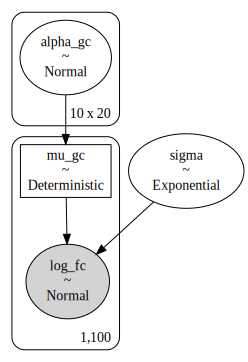

In [16]:
pm.model_to_graphviz(m7a_pool)

In [17]:
az_m7a_pool = az.from_pymc3(
    trace=m7a_pool_trace,
    model=m7a_pool,
    posterior_predictive=m7a_pool_post_check,
    prior=m7a_pool_prior_check,
)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [18]:
m7a_pool_post = (
    az.summary(az_m7a_pool, var_names=["alpha_gc"])
    .reset_index()
    .rename(columns={"index": "intercept"})
    .assign(
        gene_idx=lambda d: d["intercept"].str.extract(r"\[(\d+),"),
        cell_line_idx=lambda d: d["intercept"].str.extract(r",(\d+)\]"),
    )
    .assign(
        gene_idx=lambda d: [int(x) for x in d.gene_idx],
        gene=lambda d: [genes[i] for i in d.gene_idx],
        cell_line_idx=lambda d: [int(x) for x in d.cell_line_idx],
        cell_line=lambda d: [cell_lines[i] for i in d.cell_line_idx],
    )
)
m7a_pool_post.head(n=10)

,intercept,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,gene_idx,cell_line_idx,gene,cell_line
0,"alpha_gc[0,0]",-0.966,0.340,-1.615,-0.333,0.003,0.002,12413.0,10757.0,12382.0,5739.0,1.0,0,0,gene_0,cell_0
1,"alpha_gc[0,1]",-2.349,0.348,-3.020,-1.710,0.003,0.002,11758.0,11251.0,11762.0,5584.0,1.0,0,1,gene_0,cell_1
2,"alpha_gc[0,2]",-0.907,0.340,-1.550,-0.274,0.003,0.002,11552.0,9620.0,11581.0,5955.0,1.0,0,2,gene_0,cell_2
3,"alpha_gc[0,3]",-0.770,0.351,-1.399,-0.085,0.003,0.002,13773.0,10072.0,13783.0,5782.0,1.0,0,3,gene_0,cell_3
4,"alpha_gc[0,4]",-2.849,0.347,-3.503,-2.186,0.003,0.002,15364.0,14853.0,15340.0,6178.0,1.0,0,4,gene_0,cell_4
5,"alpha_gc[0,5]",-3.114,0.356,-3.748,-2.426,0.003,0.002,15264.0,15264.0,15290.0,5429.0,1.0,0,5,gene_0,cell_5
6,"alpha_gc[0,6]",-0.793,0.345,-1.445,-0.134,0.003,0.002,12937.0,10412.0,12951.0,6447.0,1.0,0,6,gene_0,cell_6
7,"alpha_gc[0,7]",-1.723,0.352,-2.413,-1.105,0.003,0.002,12401.0,11951.0,12422.0,5660.0,1.0,0,7,gene_0,cell_7
8,"alpha_gc[0,8]",-1.690,0.347,-2.317,-1.028,0.003,0.002,13534.0,12979.0,13550.0,5134.0,1.0,0,8,gene_0,cell_8
9,"alpha_gc[0,9]",-0.413,0.346,-1.064,0.233,0.003,0.003,14611.0,7202.0,14599.0,5734.0,1.0,0,9,gene_0,cell_9


Note that there is more pooling in the first genes than the later genes.
The first gene has 1 sgRNA and the last gene has 10 sgRNA.

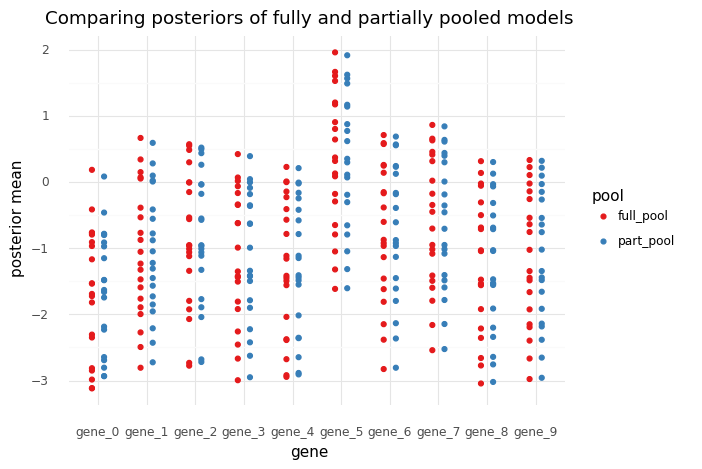

<ggplot: (8759221233378)>

In [19]:
var_names = ["gene", "cell_line", "mean"]
m7a_compare_post = pd.merge(
    m7a_post[var_names].rename(columns={"mean": "part_pool"}),
    m7a_pool_post[var_names].rename(columns={"mean": "full_pool"}),
    on=["gene", "cell_line"],
).melt(id_vars=["gene", "cell_line"], var_name="pool", value_name="mean")

for col in ["gene", "cell_line"]:
    m7a_compare_post = make_cat(m7a_compare_post, col)

(
    gg.ggplot(m7a_compare_post, gg.aes(x="gene", y="mean"))
    + gg.geom_point(gg.aes(color="pool"), position=gg.position_dodge(width=0.5))
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.labs(
        x="gene",
        y="posterior mean",
        title="Comparing posteriors of fully and partially pooled models",
    )
)

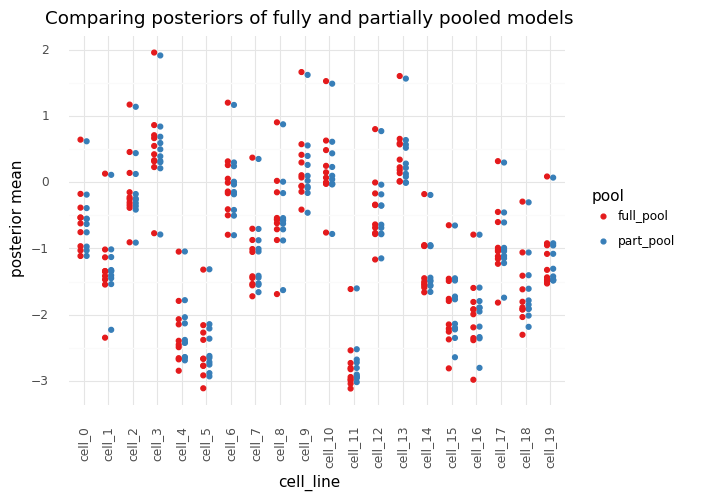

<ggplot: (8759221925554)>

In [20]:
(
    gg.ggplot(m7a_compare_post, gg.aes(x="cell_line", y="mean"))
    + gg.geom_point(gg.aes(color="pool"), position=gg.position_dodge(width=0.5))
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(axis_text_x=gg.element_text(angle=90))
    + gg.labs(
        x="cell_line",
        y="posterior mean",
        title="Comparing posteriors of fully and partially pooled models",
    )
)

In [21]:
az.summary(az_m7a, var_names=["mu_alpha_gc", "sigma_alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha_gc,-0.936,0.082,-1.094,-0.787,0.001,0.001,11858.0,11826.0,11823.0,5764.0,1.0
sigma_alpha,1.110,0.058,1.000,1.216,0.001,0.000,13260.0,13026.0,13424.0,6046.0,1.0


## Model 7b. A d-Dimensional varying intercept with a hierarchical link between the sgRNA and gene

$
logFC_{i,s,c} \sim \mathcal{N}(\mu_{s,c}, \sigma) \\
\mu_{s,c} = \alpha_{s,c} \\
\quad \alpha_{s,c} \sim \mathcal{N}(\mu_{\alpha_{s,c}}, \sigma_\alpha) \\
\qquad \mu_{\alpha_{s,c}} = \gamma_{g,c} \\
\qquad\quad \gamma_{g,c} \sim \mathcal{N}(\mu_\gamma, \sigma_\gamma) \\
\qquad\qquad \mu_\gamma \sim \mathcal{N}(0,5) \quad \sigma_\gamma \sim \text{Exp}(1) \\
\qquad \sigma_\alpha \sim \text{Exp}(1) \\
\sigma \sim \text{Exp}(1)
$

In [ ]:
gene_idx = data.gene.cat.codes.to_list()
cell_line_idx = data.cell_line.cat.codes.to_list()

with pm.Model() as m7a:
    # Hyper-priors
    mu_alpha_gc = pm.Normal("mu_alpha_gc", 0, 5)
    sigma_alpha = pm.Exponential("sigma_alpha", 1)

    # Linear model parameters
    alpha_gc = pm.Normal(
        "alpha_gc", mu_alpha_gc, sigma_alpha, shape=(num_genes, num_cell_lines)
    )

    # Linear model
    mu_gc = pm.Deterministic("mu_gc", alpha_gc[gene_idx, cell_line_idx])
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    log_fc = pm.Normal("log_fc", mu_gc, sigma, observed=data.log_fc.to_list())

    # Sampling
    m7a_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    m7a_trace = pm.sample(2000, tune=2000, random_seed=RANDOM_SEED, target_accept=0.95)
    m7a_post_check = pm.sample_posterior_predictive(m7a_trace, random_seed=RANDOM_SEED)

In [59]:
sgrna_idx = data.sgRNA.cat.codes.to_list()
gene_idx = data.gene.cat.codes.to_list()
sgrna_to_gene_idx = sgrna_df.gene.cat.codes.to_list()
cell_line_idx = data.cell_line.cat.codes.to_list()

with pm.Model() as m7b:
    # Priors for varying intercept for [gene, cell line].
    mu_gamma = pm.Normal("mu_gamma", 0, 5)
    sigma_gamma = pm.Exponential("sigma_gamma", 1)

    # Varying intercept for [gene, cell line].
    gamma_gc = pm.Normal(
        "gamma_gc", mu_gamma, sigma_gamma, shape=(num_genes, num_cell_lines)
    )

    # Priors for varying intercept for [sgRNA, cell line].
    mu_alpha_sc = pm.Deterministic("mu_alpha_sc", gamma_gc[sgrna_to_gene_idx,])
    sigma_alpha = pm.Exponential("sigma_alpha", 1)

    # Varying intercept for [sgRNA, cell line].
    alpha_sc = pm.Normal(
        "alpha_sc", mu_alpha_sc, sigma_alpha, shape=(num_sgrnas, num_cell_lines)
    )

    # level 0. Linear model
    mu_sc = pm.Deterministic("mu_gc", alpha_sc[sgrna_idx, cell_line_idx])
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    log_fc = pm.Normal("log_fc", mu_sc, sigma, observed=data.log_fc.to_list())

    # Sampling
    m7b_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    m7b_trace = pm.sample(2000, tune=2000, random_seed=RANDOM_SEED, target_accept=0.95)
    m7b_post_check = pm.sample_posterior_predictive(m7b_trace, random_seed=RANDOM_SEED)

ValueError: operands could not be broadcast together with shapes (55,20) (1100,20) 

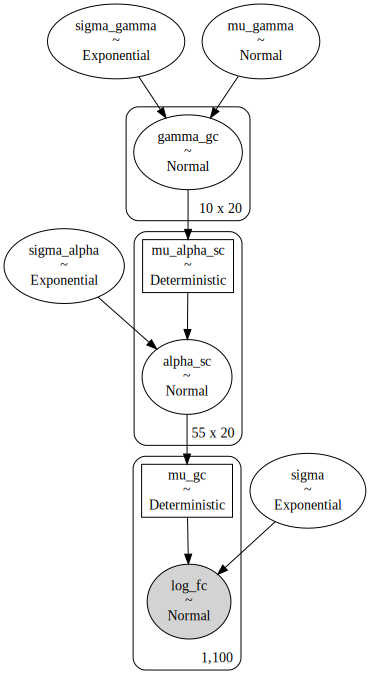

In [44]:
pm.model_to_graphviz(m7b)

In [45]:
az_m7b = az.from_pymc3(
    trace=m7b_trace,
    model=m7b,
    posterior_predictive=m7b_post_check,
    prior=m7b_prior_check,
)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [83]:
sgrna_idx = data.sgRNA.cat.codes.to_list()
cell_line_idx = data.cell_line.cat.codes.to_list()

with pm.Model() as m7b_pool:

    # Linear model parameters
    alpha_sc = pm.Normal("alpha_sc", 0, 5, shape=(num_sgrnas, num_cell_lines))

    # Linear model
    mu_sc = pm.Deterministic("mu_sc", alpha_sc[sgrna_idx, cell_line_idx])
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    log_fc = pm.Normal("log_fc", mu_sc, sigma, observed=data.log_fc.to_list())

    # Sampling
    m7b_pool_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    m7b_pool_trace = pm.sample(
        2000, tune=2000, random_seed=RANDOM_SEED, target_accept=0.95
    )
    m7b_pool_post_check = pm.sample_posterior_predictive(
        m7b_pool_trace, random_seed=RANDOM_SEED
    )

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_sc]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 67 seconds.
The acceptance probability does not match the target. It is 0.9012349306269171, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8568385429631933, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


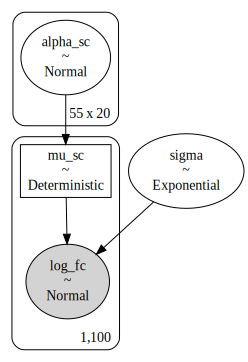

In [82]:
pm.model_to_graphviz(m7b_pool)

In [86]:
az_m7b_pool = az.from_pymc3(
    trace=m7b_pool_trace,
    model=m7b_pool,
    posterior_predictive=m7b_pool_post_check,
    prior=m7b_pool_prior_check,
)

/home/jc604/.conda/envs/speclet/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [88]:
az.summary(az_m7b, var_names=["mu_gamma", "sigma_gamma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_gamma,-0.937,0.080,-1.091,-0.791,0.001,0.001,7195.0,7036.0,7238.0,4670.0,1.0
sigma_gamma,1.111,0.057,1.004,1.217,0.001,0.000,7371.0,7240.0,7566.0,5498.0,1.0


In [49]:
m7b_post = (
    az.summary(az_m7b, var_names=["gamma_gc"])
    .reset_index()
    .rename(columns={"index": "intercept"})
    .assign(
        gene_idx=lambda d: d["intercept"].str.extract(r"\[(\d+),"),
        cell_line_idx=lambda d: d["intercept"].str.extract(r",(\d+)\]"),
    )
    .assign(
        gene_idx=lambda d: [int(x) for x in d.gene_idx],
        gene=lambda d: [genes[i] for i in d.gene_idx],
        cell_line_idx=lambda d: [int(x) for x in d.cell_line_idx],
        cell_line=lambda d: [cell_lines[i] for i in d.cell_line_idx],
    )
)
m7b_post.head(n=10)

,intercept,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,gene_idx,cell_line_idx,gene,cell_line
0,"gamma_gc[0,0]",-0.973,0.333,-1.581,-0.323,0.004,0.003,7409.0,7210.0,7413.0,5646.0,1.0,0,0,gene_0,cell_0
1,"gamma_gc[0,1]",-2.238,0.338,-2.845,-1.579,0.004,0.003,6961.0,6710.0,6937.0,5555.0,1.0,0,1,gene_0,cell_1
2,"gamma_gc[0,2]",-0.919,0.335,-1.535,-0.297,0.004,0.003,6872.0,6710.0,6853.0,5865.0,1.0,0,2,gene_0,cell_2
3,"gamma_gc[0,3]",-0.786,0.332,-1.411,-0.162,0.004,0.003,7373.0,6793.0,7375.0,5699.0,1.0,0,3,gene_0,cell_3
4,"gamma_gc[0,4]",-2.688,0.343,-3.329,-2.043,0.004,0.003,6362.0,6362.0,6365.0,4661.0,1.0,0,4,gene_0,cell_4
5,"gamma_gc[0,5]",-2.933,0.332,-3.541,-2.306,0.004,0.003,6775.0,6698.0,6768.0,5607.0,1.0,0,5,gene_0,cell_5
6,"gamma_gc[0,6]",-0.798,0.335,-1.407,-0.153,0.004,0.003,6232.0,6019.0,6225.0,5431.0,1.0,0,6,gene_0,cell_6
7,"gamma_gc[0,7]",-1.659,0.333,-2.278,-1.021,0.004,0.003,6903.0,6903.0,6903.0,5653.0,1.0,0,7,gene_0,cell_7
8,"gamma_gc[0,8]",-1.630,0.336,-2.251,-0.997,0.004,0.003,6776.0,6623.0,6773.0,5693.0,1.0,0,8,gene_0,cell_8
9,"gamma_gc[0,9]",-0.461,0.325,-1.090,0.128,0.004,0.003,6099.0,5351.0,6106.0,5485.0,1.0,0,9,gene_0,cell_9


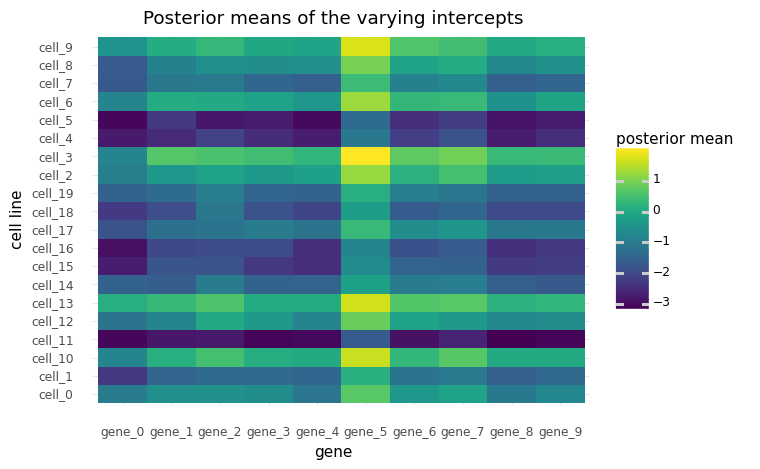

<ggplot: (8759130021130)>

In [50]:
(
    gg.ggplot(m7b_post, gg.aes(x="gene", y="cell_line"))
    + gg.geom_tile(gg.aes(fill="mean"))
    + gg.labs(
        x="gene",
        y="cell line",
        fill="posterior mean",
        title="Posterior means of the varying intercepts",
    )
)

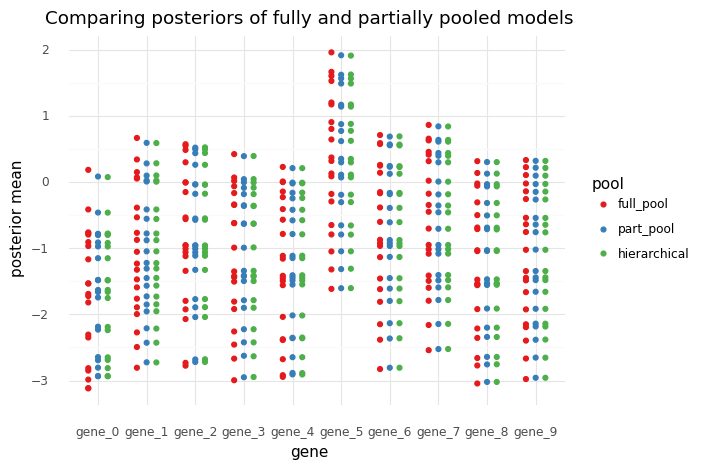

<ggplot: (8759129885284)>

In [57]:
var_names = ["gene", "cell_line", "mean"]
m7ab_compare_post = (
    pd.merge(
        m7a_pool_post[var_names].rename(columns={"mean": "full_pool"}),
        m7a_post[var_names].rename(columns={"mean": "part_pool"}),
        on=["gene", "cell_line"],
    )
    .merge(
        m7b_post[var_names].rename(columns={"mean": "hierarchical"}),
        on=["gene", "cell_line"],
    )
    .melt(id_vars=["gene", "cell_line"], var_name="pool", value_name="mean")
)

for col in ["gene", "cell_line", "pool"]:
    m7ab_compare_post = make_cat(m7ab_compare_post, col)


(
    gg.ggplot(m7ab_compare_post, gg.aes(x="gene", y="mean"))
    + gg.geom_point(gg.aes(color="pool"), position=gg.position_dodge(width=0.6))
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.labs(
        x="gene",
        y="posterior mean",
        title="Comparing posteriors of fully and partially pooled models",
    )
)

In [90]:
def parse_alpha_sc(az_obj):
    post_df = (
        az.summary(az_obj, var_names=["alpha_sc"])
        .reset_index()
        .rename(columns={"index": "intercept"})
        .assign(
            sgrna_idx=lambda d: d["intercept"].str.extract(r"\[(\d+),"),
            cell_line_idx=lambda d: d["intercept"].str.extract(r",(\d+)\]"),
        )
        .assign(
            sgrna_idx=lambda d: [int(x) for x in d.sgrna_idx],
            sgRNA=lambda d: [sgrnas[i] for i in d.sgrna_idx],
            cell_line_idx=lambda d: [int(x) for x in d.cell_line_idx],
            cell_line=lambda d: [cell_lines[i] for i in d.cell_line_idx],
            gene=lambda d: [genes[sgrna_to_gene_idx[i]] for i in d.sgrna_idx],
        )
    )
    
    for col in ["gene", "cell_line", "sgRNA"]:
        post_df = make_cat(m7b_post, col)
    
    return post_df


m7b_alpha_sc = parse_alpha_sc(az_m7b)
m7b_pool_alpha_sc = parse_alpha_sc(az_m7b_pool)

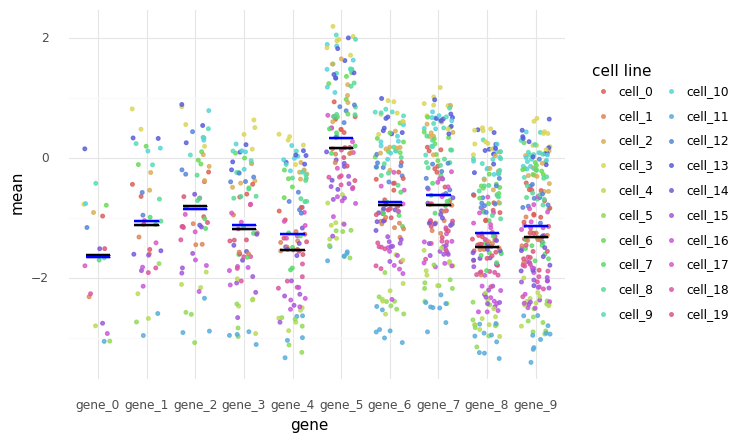

<ggplot: (8759167098025)>

In [91]:
gene_posteriors = m7b_alpha_sc[["gene", "mean"]].groupby("gene").mean().reset_index()

(
    gg.ggplot(m7b_alpha_sc, gg.aes(x="gene", y="mean"))
    + gg.geom_jitter(gg.aes(color="cell_line"), height=0, width=0.3, alpha=0.8, size=1)
    + gg.scale_color_discrete(guide=gg.guide_legend(title="cell line", ncol=2))
    + gg.geom_crossbar(
        gg.aes(ymin="log_fc", ymax="log_fc", y="log_fc"), data=real_gene_vals
    )
    + gg.geom_crossbar(
        gg.aes(ymin="mean", ymax="mean", y="mean"), data=gene_posteriors, color="blue"
    )
)

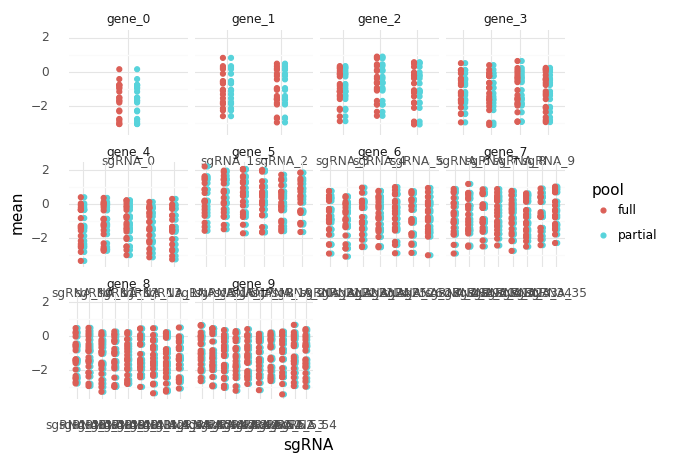

<ggplot: (8759127025655)>

In [104]:
compare_alpha_sc = pd.concat([
    m7b_alpha_sc.assign(pool="partial"),
    m7b_pool_alpha_sc.assign(pool="full")
])

(
    gg.ggplot(compare_alpha_sc, gg.aes(x="sgRNA", y="mean"))
    + gg.facet_wrap("gene", scales="free_x")
    + gg.geom_point(gg.aes(color="pool"), position=gg.position_dodge(width=0.3))
)

**TODO:** Plot of the varying intercept values for sgRNA and cell line in `az_m7b` vs `az_m7b_pool` as x and y to show shrinkage.

---

In [22]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

numpy    1.19.2
pymc3    3.9.3
pandas   1.1.3
arviz    0.10.0
seaborn  0.11.0
plotnine 0.7.1
last updated: 2020-11-09 

CPython 3.8.5
IPython 7.18.1

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-1062.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 28
interpreter: 64bit
host name  : compute-e-16-235.o2.rc.hms.harvard.edu
Git branch : models
